In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 논문 데이터 셋

In [71]:
k=2
num_timestep = 10000
y = np.zeros(num_timestep)
y[0]=1
y[1]=-2
np.random.seed(0)

time_range = np.arange(num_timestep)
coef = [0.6,-0.5]

change_size = 0
for t in range(2,num_timestep):
    noise = np.random.randn()   
    if t % 1000 ==0: # 1000의 배수마다 change point 설정
        change = t//1000
        change_size += change
    
    # AR 모델 + change point를 고려
    y[t] = coef[0]* y[t-1] + coef[1]*y[t-2] + noise + change_size

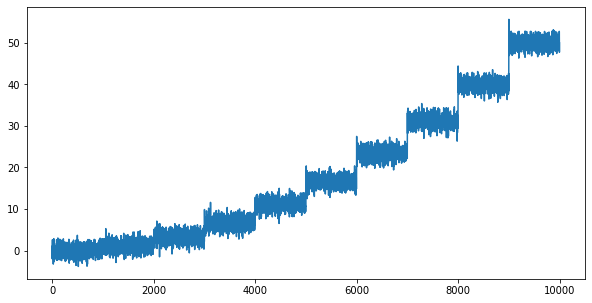

In [72]:
fig, axs = plt.subplots(figsize=(10,5))
plt.plot(time_range, y)

# initial parameter

In [74]:
t = 20
series = y[:t]
series

array([ 1.        , -2.        ,  0.06405235,  1.43858862,  1.80986498,
        2.60751788,  2.52713623, -0.76475508, -0.77233275, -0.23237931,
        0.14351993,  0.61290012,  0.44002368,  1.41183765,  1.38812848,
        0.24863328, -0.10102104,  0.14874506,  1.63383663,  0.70077118])

In [75]:
mean= np.mean(series[-k:])
mean

1.167303907634587

In [76]:
k=2
autocovariance = []
for lag in range(k + 1):
    n = len(series)
    acov = np.mean((series[k:n] - mean) * (series[k-lag:n-lag] - mean))
    autocovariance.append(acov)
    
autocovariance

[1.1666402957637734, 0.773865260495972, 0.038314612523011785]

In [77]:
# Calculate the autocovariance: [C1,C2,C3..Ck]
# k=2 : [C1,C2]

autocovariance_1 = []
for lag in range(1,k + 1):
    n = len(series)
    acov = np.mean((series[k:n] - mean) * (series[k-lag:n-lag] - mean))
    autocovariance_1.append(acov)
    
autocovariance_1

[0.773865260495972, 0.038314612523011785]

In [78]:
autocovariance_0 = []
for lag in range(k):
    n = len(series)
    acov = np.mean((series[k:n] - mean) * (series[k-lag:n-lag] - mean))
    autocovariance_0.append(acov)

autocovariance_0

[1.1666402957637734, 0.773865260495972]

In [79]:
# covariance_matrix
cov_matrix = np.zeros((k,k))
for i in range(k):
    for j in range(k):
        cov_matrix[i][j] = autocovariance_1[np.abs(i-j)]
cov_matrix

array([[0.77386526, 0.03831461],
       [0.03831461, 0.77386526]])

In [80]:
# w1, w2, w3 다시 구해보기
# Construct matrix

equation_matrix = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        if j <= i:
            equation_matrix[i, j] = autocovariance_0[i-j]
        else:
            equation_matrix[i,j] = 0
        
equation_matrix

array([[1.1666403 , 0.        ],
       [0.77386526, 1.1666403 ]])

In [81]:
ar_coefficients = np.linalg.solve(equation_matrix, autocovariance_1)
ar_coefficients

array([ 0.66332807, -0.4071623 ])

In [82]:
# Xt-1, Xt-2
series[-k:][::-1]

array([0.70077118, 1.63383663])

In [83]:
# w
w= ar_coefficients * (series[-k:][::-1]-mean) + mean
w

array([0.85783965, 0.97734937])

In [85]:
from scipy.stats import multivariate_normal

class MultivariateARModel:
    def __init__(self, order, mean_vector, covariance_matrix):
        """
        Initialize the MultivariateARModel class.

        Parameters:
            order (int): The order of the AR model.
            mean_vector (numpy array): The mean vector of the AR model.
            covariance_matrix (numpy array): The covariance matrix of the AR model.
        """
        self.order = order
        self.mean_vector = mean_vector
        self.covariance_matrix = covariance_matrix

    def multivariate_pdf(self, data):
        """
        Calculate the multivariate probability density function (PDF) in the AR model.

        Parameters:
            data (numpy array): The input data containing observations.

        Returns:
            numpy array: The PDF values for each observation.
        """
#         pdf_values = np.zeros(data.shape[0])

        observation = data[-self.order:][::-1]
        pdf_values = multivariate_normal.pdf(observation, mean=self.mean_vector, cov=self.covariance_matrix)

        return pdf_values

In [86]:
multi_armodel = MultivariateARModel(k, mean_vector=w, covariance_matrix=cov_matrix)
multi_armodel.multivariate_pdf(series)

0.1522813760406271

# update parameter

In [87]:
# discount factor
r = 0.005
t = t+1
series = y[:t]
print("새로 추가된 데이터:", series)

새로 추가된 데이터: [ 1.         -2.          0.06405235  1.43858862  1.80986498  2.60751788
  2.52713623 -0.76475508 -0.77233275 -0.23237931  0.14351993  0.61290012
  0.44002368  1.41183765  1.38812848  0.24863328 -0.10102104  0.14874506
  1.63383663  0.70077118 -0.0833879 ]


In [88]:
# update mean
mean = (1-r) * mean + r * series[-1]

In [89]:
# update covariance
new_autocovariance_1 = []
for lag,acov in enumerate(autocovariance_1):
    new_acov = (1-r) * acov + r * (series[-1]-mean) * (series[-lag]-mean) 
    new_autocovariance_1.append(new_acov)
    
new_autocovariance_1

[0.7709980209683718, 0.04586617353266119]

In [91]:
# update covariance
new_autocovariance_0 = []
for lag,acov in enumerate(autocovariance_0):
    new_acov = (1-r) * acov + r * (series[-1]-mean) * (series[-lag]-mean)
    new_autocovariance_0.append(new_acov)
    
new_autocovariance_0

[1.1618091810598339, 0.7777390682657567]

In [92]:
# covariance_matrix
cov_matrix = np.zeros((k,k))
for i in range(k):
    for j in range(k):
        cov_matrix[i][j] = new_autocovariance_1[np.abs(i-j)]
cov_matrix

array([[0.77099802, 0.04586617],
       [0.04586617, 0.77099802]])

In [93]:
# update w1, w2, w3 
# Construct matrix

equation_matrix = np.zeros((k, k))
for i in range(k):
    for j in range(k):
        if j <= i:
            equation_matrix[i, j] = new_autocovariance_0[i-j]
        else:
            equation_matrix[i,j] = 0
        
equation_matrix

array([[1.16180918, 0.        ],
       [0.77773907, 1.16180918]])

In [94]:
# update result
ar_coefficients = np.linalg.solve(equation_matrix, new_autocovariance_1)
ar_coefficients

array([ 0.66361846, -0.40476168])

In [95]:
# update w
w= ar_coefficients * (series[-2:][::-1]-mean) + mean
w

array([0.33521818, 1.34735385])

In [96]:
multi_armodel = MultivariateARModel(k, mean_vector=w, covariance_matrix=cov_matrix)
multi_armodel.multivariate_pdf(series)

0.14353098040708218

# 함수화

In [108]:
def update_mean(series,mean,r):
    mean = (1-r) * mean + r * series[-1]
    return mean

def update_covariance(series,autocovariance,r):
    new_autocovariance = []
    for lag,acov in enumerate(autocovariance):
        new_acov = (1-r) * acov + r * (series[-1]-mean) * (series[-lag]-mean) 
        new_autocovariance.append(new_acov)
        
    return new_autocovariance

def make_cov_matrix(autocovariance,order):
    
    autocovariance_1 = autocovariance[1:]
    
    cov_matrix = np.zeros((order,order))
    for i in range(k):
        for j in range(k):
            cov_matrix[i][j] = new_autocovariance_1[np.abs(i-j)]
            
    return cov_matrix

def get_AR_coefficients(autocovariance, k):
    
    autocovariance_0 = autocovariance[:-1]
    autocovariance_1 = autocovariance[1:]
    
    equation_matrix = np.zeros((k, k))
    for i in range(k):
        for j in range(k):
            if j <= i:
                equation_matrix[i, j] = autocovariance_0[i-j]
            else:
                equation_matrix[i,j] = 0
    
    ar_coefficients = np.linalg.solve(equation_matrix, autocovariance_1)
    
    return ar_coefficients

def get_mean_vector(ar_coefficients, order, mean):
    
    w= ar_coefficients * (series[-order:][::-1]-mean) + mean
    
    return w
    

In [109]:
class SDAR_Model:
    def __init__(self,series, order, mean_vector,covariance_matrix):
        """
        Initialize the MultivariateARModel class.

        Parameters:
            order (int): The order of the AR model.
            mean_vector (numpy array): The mean vector of the AR model.
            covariance_matrix (numpy array): The covariance matrix of the AR model.
        """
        self.series = series
        self.order = order
        self.mean_vector = mean_vector
        self.covariance_matrix = covariance_matrix

    def gaussian_normal_pdf(self):
        """
        Calculate the multivariate probability density function (PDF) in the AR model.

        Returns:
            numpy array: The PDF values for each observation.
        """
#         pdf_values = np.zeros(data.shape[0])

        observation = series[-self.order:][::-1]
        pdf_values = multivariate_normal.pdf(observation, mean=self.mean_vector, cov=self.covariance_matrix)

        return pdf_values

In [110]:
series = y[:20]
order = 2

# initial parameter

mean= np.mean(series[-order:])

autocovariance = []
for lag in range(order + 1):
    n = len(series)
    acov = np.mean((series[order:n] - mean) * (series[order-lag:n-lag] - mean))
    autocovariance.append(acov)
    
autocovariance_1 = autocovariance[1:]
autocovariance_0 = autocovariance[:-1]

# covariance_matrix
cov_matrix = np.zeros((order,order))
for i in range(order):
    for j in range(order):
        cov_matrix[i][j] = autocovariance_1[np.abs(i-j)]
        
# get ar coefficients

equation_matrix = np.zeros((order, order))
for i in range(order):
    for j in range(order):
        if j <= i:
            equation_matrix[i, j] = autocovariance_0[i-j]
        else:
            equation_matrix[i,j] = 0
            
ar_coefficients = np.linalg.solve(equation_matrix, autocovariance_1)

# mean_vector(w)
w= ar_coefficients * (series[-order:][::-1]-mean) + mean

sdar_model = SDAR_Model(series, order, mean_vector=w, covariance_matrix=cov_matrix)
pdf_value = sdar_model.gaussian_normal_pdf()
pdf_value

0.1522813760406271

In [111]:
# 데이터 하나씩 업데이트
r = 0.005

probability_list = []

for t in range(20+1,5100):
    series = y[:t]
    
    mean = update_mean(series, mean, r)
    autocovariance = update_covariance(series,autocovariance,r)
    
    cov_matrix =  make_cov_matrix(autocovariance,order)
    
    ar_coefficients = get_AR_coefficients(autocovariance, order)
    
    w = get_mean_vector(ar_coefficients, order, mean)
    
    sdar_model = SDAR_Model(series, order, mean_vector=w, covariance_matrix=cov_matrix)
    pdf_value = sdar_model.gaussian_normal_pdf()
    probability_list.append(pdf_value)

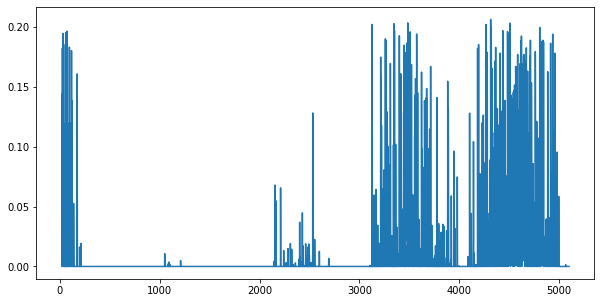

In [112]:
time_range = np.arange(21,5100)
fig, axs = plt.subplots(figsize=(10,5))
plt.plot(time_range, probability_list)

# 시각화